In [ ]:
%pip install -q --upgrade langchain langgraph langchain_openai langchain_core langgraph-supervisor python-dotenv

#### Exemplo de agente simples **com Supervisor e Tool Calling** criado usando LangGraph, LangChain e o modelo Gemini-2.0 chamado via OpenRouter

Cria o nosso LLM usando o modelo escolhido

In [ ]:
import os
from typing import Optional

from dotenv import load_dotenv
from langchain_core.utils.utils import secret_from_env
from langchain_openai import ChatOpenAI
from pydantic import Field, SecretStr

load_dotenv()


# Modifica a classe que cria o modelo pra aceitar a API do OpenRouter
class ChatOpenRouter(ChatOpenAI):
    openai_api_key: Optional[SecretStr] = Field(
        alias="api_key", default_factory=secret_from_env("OPENROUTER_API_KEY", default=None)
    )

    @property
    def lc_secrets(self) -> dict[str, str]:
        return {"openai_api_key": "OPENROUTER_API_KEY"}

    def __init__(self, openai_api_key: Optional[str] = None, **kwargs):
        openai_api_key = openai_api_key or os.environ.get("OPENROUTER_API_KEY")
        super().__init__(base_url="https://openrouter.ai/api/v1", openai_api_key=openai_api_key, **kwargs)


llm = ChatOpenRouter(model_name="google/gemini-2.0-flash-001")

Cria os agentes especializados e as tools usadas por cada um

In [ ]:
import datetime

from langgraph.prebuilt import create_react_agent


# Agent 1 - Time Keeper
def currentTime() -> datetime:
    "This tool provides the current date and time."
    dt = datetime.datetime.now()
    return f"Datetime is {dt} and today is {dt.strftime('%A')}"


time_keeper_agent = create_react_agent(
    model=llm,
    tools=[currentTime],
    name="time_keeper_agent",
    prompt="You tell the current date, time and day of the week in your location.",
)


# Agent 2 - Schedule Keeper
def shopOpeningHours() -> str:
    "This tool provides the daily opening hours schedule for a shop."
    schedule = "\n".join(
        [
            "Monday 10:00am to 09:00pm",
            "Tuesday 10:00am to 09:00pm",
            "Wednesday 10:00am to 09:00pm",
            "Thursday 10:00am to 09:00pm",
            "Friday 10:00am to 09:00pm",
            "Saturday 10:00am to 09:00pm",
            "Sunday 10:00am to 09:00pm",
        ]
    )
    return schedule


schedule_keeper_agent = create_react_agent(
    model=llm,
    tools=[shopOpeningHours],
    name="schedule_keeper_agent",
    prompt="You tell the shop operating hours for each day of the week.",
)

Cria o supervisor que irá invocar cada um dos agentes

In [ ]:
from langgraph_supervisor import create_supervisor

supervisor_prompt = "\n".join(
    [
        "You are a team supervisor to manage time_keeper_agent and schedule_keeper_agent",
        "Your job is to respond to shop opening hour queries using time_keeper_agent and schedule_keeper_agent.",
        "To get the current time and date use time_keeper_agent and",
        "for getting shop's operating hours use schedule_keeper_agent",
        "You can use both agents in aprallel to get required information.",
    ]
)

workflow = create_supervisor(
    agents=[schedule_keeper_agent, time_keeper_agent], model=llm, output_mode="full_history", prompt=supervisor_prompt
)

Compila o state graph e envia uma mensagem ao nosso agente

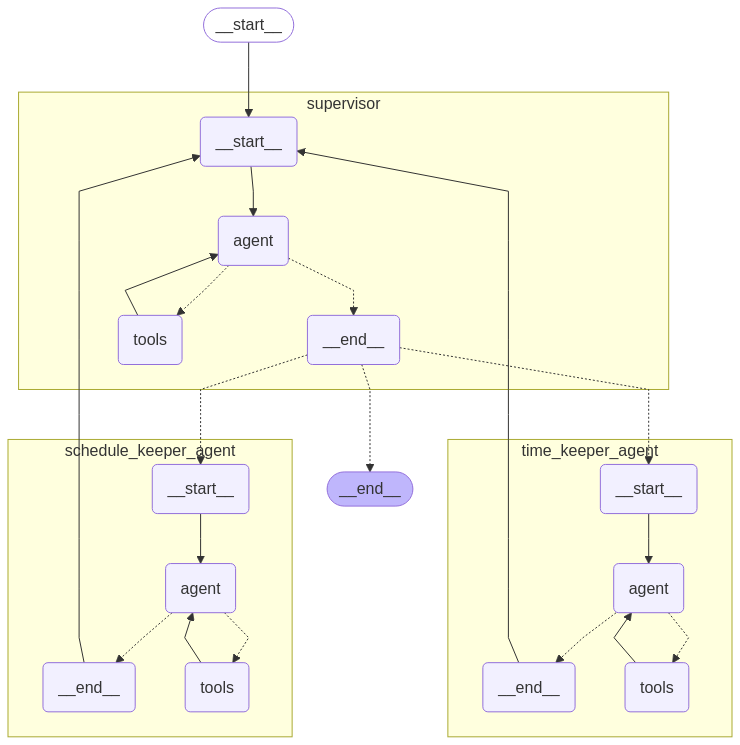

================================ Human Message =================================

What are the shop's opening hours on the weekend? is the shop open right now?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_schedule_keeper_agent (tool_0_transfer_to_schedule_keeper_agent)
 Call ID: tool_0_transfer_to_schedule_keeper_agent
  Args:
================================= Tool Message =================================
Name: transfer_to_schedule_keeper_agent

Successfully transferred to schedule_keeper_agent
================================== Ai Message ==================================
Name: schedule_keeper_agent
Tool Calls:
  shopOpeningHours (tool_0_shopOpeningHours)
 Call ID: tool_0_shopOpeningHours
  Args:
================================= Tool Message =================================
Name: shopOpeningHours

Monday 10:00am to 09:00pm
Tuesday 10:00am to 09:00pm
Wednesday 10:00am to 09:00pm
Thursday 10:00am to 09:00

In [ ]:
from IPython.display import Image

app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

result = app.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What are the shop's opening hours on the weekend? is the shop open right now?",
            }
        ]
    }
)


for msg in result["messages"]:
    msg.pretty_print()